In [1]:
from asr import ASR
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from numpy import genfromtxt

data_path = os.getcwd()+'/Raw/'
data_file = 'Svea_record_session1-[2020.07.02-19.19.49].csv'
mat_fname = os.path.join(data_path, data_file)
data1 = genfromtxt(mat_fname, skip_header = 1)
data1 = np.nan_to_num(data1, copy = False)
#record-[2020.07.02-18.14.02].csv

#mne.io.read_raw_edf??
from numpy import genfromtxt

data_path = os.getcwd()+'/Raw/'
data_file = 'svea_record-session2[2020.07.02-21.45.06].csv'
mat_fname = os.path.join(data_path, data_file)
#Svea_record_session1-[2020.07.02-19.19.49]
data2 = genfromtxt(mat_fname, delimiter=',')
data2 = np.nan_to_num(data2, copy = False)
#record-[2020.07.02-18.14.02].csv




In [3]:
#LOADING DATA
#---------------
#Get data path and load data

ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
sfreq=250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq,  ch_types='eeg')
raw1 = mne.io.RawArray(data1, info)
raw2 = mne.io.RawArray(data2[:,3:11].T, info)


Creating RawArray with float64 data, n_channels=8, n_times=434690
    Range : 0 ... 434689 =      0.000 ...  1738.756 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=422145
    Range : 0 ... 422144 =      0.000 ...  1688.576 secs
Ready.


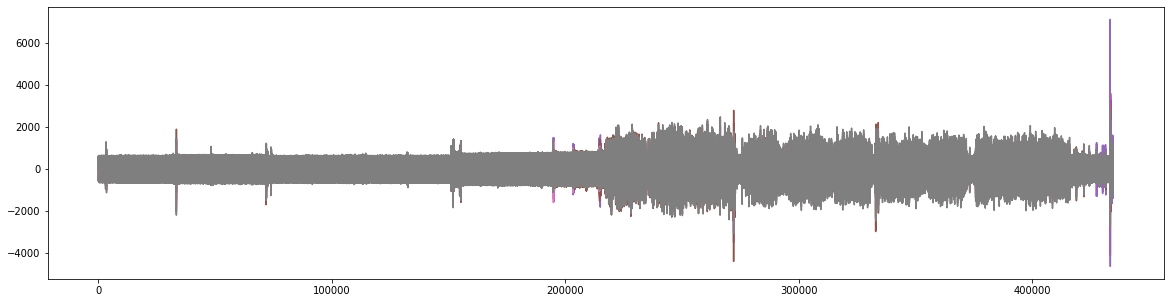

In [4]:
#plot raw data
plt.figure(figsize=(20,5))
plt.plot(raw1.get_data().T);

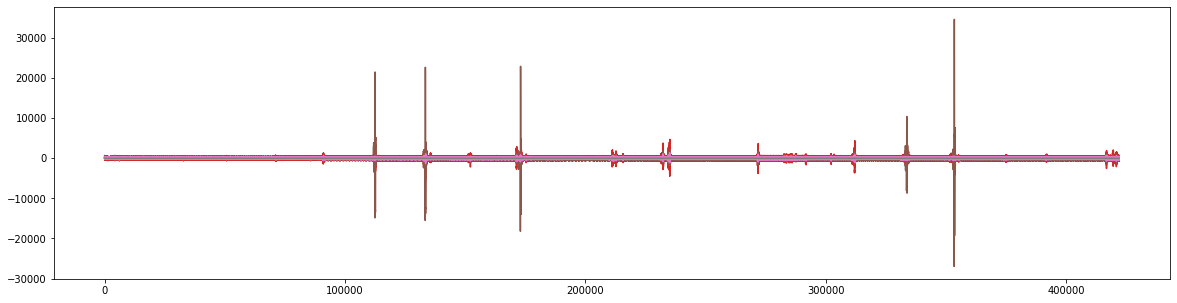

In [5]:
#plot raw data
plt.figure(figsize=(20,5))
plt.plot(raw2.get_data().T);

In [6]:
#PREPROCESSING
#---------------

In [7]:
#Seperate calibration and recording
raw_calib1 = raw1.copy()
raw_calib1.crop(tmax=60.)
raw1.crop(tmin=60.)
#Seperate calibration and recording
raw_calib2 = raw2.copy()
raw_calib2.crop(tmax=60.)
raw2.crop(tmin=60.)


<RawArray | 8 x 407145 (1628.6 s), ~24.9 MB, data loaded>

In [8]:
#initialize Artifact Subspace Reconstruction
asr1 = ASR()
asr2 = ASR()

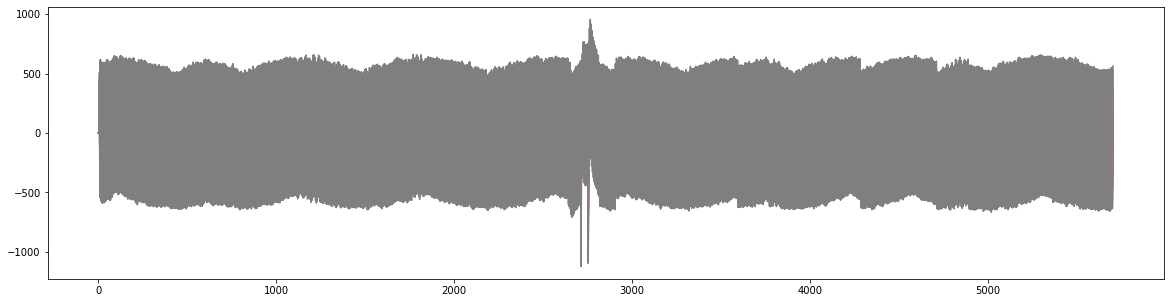

In [9]:
#plot calibration data

x_c1 = asr1.clean_windows(raw_calib1)
plt.figure(figsize=(20,5))
plt.plot(x_c1.T);


/home/matthijspals/BCI-Friendship-Lamps/asr.py:62: RuntimeWarning: invalid value encountered in true_divide
  z_scores = ((rms_scores - mu)/sig).T #shape = (n_channels, n_windows)
/home/matthijspals/.local/lib/python3.8/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/matthijspals/BCI-Friendship-Lamps/asr.py:73: RuntimeWarning: invalid value encountered in less
  np.std(z_scores, axis=0) < .1)


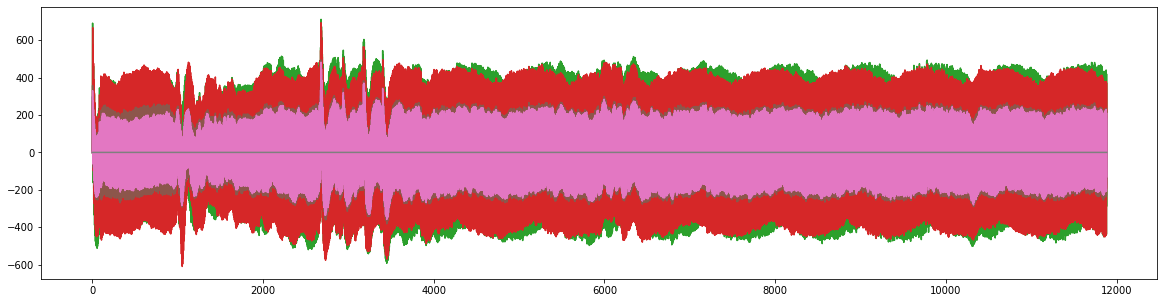

In [10]:
x_c2 = asr2.clean_windows(raw_calib2)
plt.figure(figsize=(20,5))
plt.plot(x_c2.T);

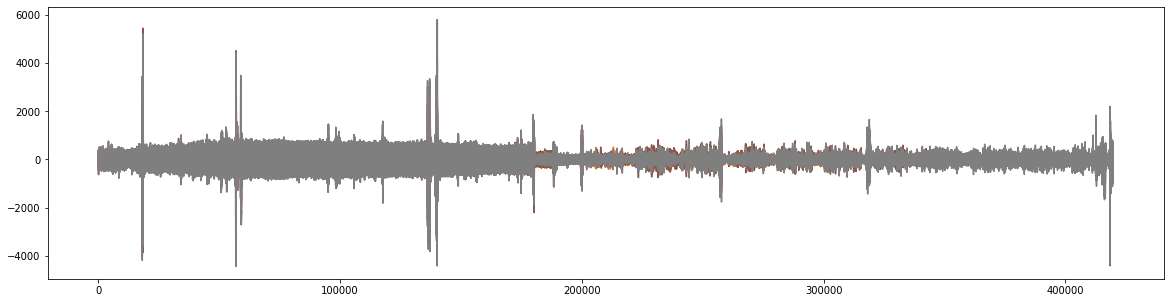

In [11]:
# clean up signal and plot - reconstruct parts with high amplitude noise such as eyeblinks
asr1.calibrate(k = 15)
out1 = asr1.clean(raw1)
plt.figure(figsize=(20,5))
plt.plot(out1.T);

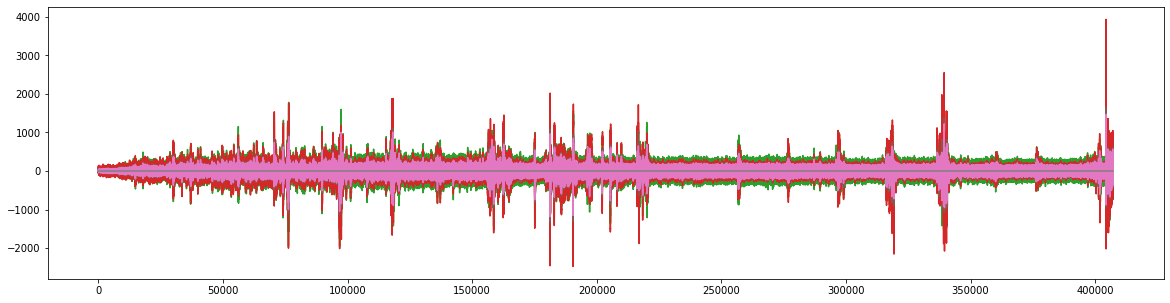

In [12]:
asr2.calibrate(k = 15)
out2 = asr2.clean(raw2)
plt.figure(figsize=(20,5))
plt.plot(out2.T);

In [13]:
250*60

15000

In [14]:
#FEATURE EXTRACTION
#---------------

#concatenate data of same trials

Meditate1 = np.empty((8,0))
Stress1 = np.empty((8,0))
Meditate2 = np.empty((8,0))
Stress2 = np.empty((8,0))



trial_offsets = range(0,len(raw1.times), 80*250)
trial_len = 60*250

for i, o in enumerate(trial_offsets):
    if i<10:
        #print(i, o)
        Meditate1 = np.concatenate((Meditate1, out1[:, o: o+trial_len]), axis = 1)
        Meditate2 = np.concatenate((Meditate2, out2[:, o: o+trial_len]), axis = 1)
    elif i<20:
        #print(i, o)
        Stress1 = np.concatenate((Stress1, out1[:, o: o+trial_len]), axis = 1)
        Stress2 = np.concatenate((Stress2, out2[:, o: o+trial_len]), axis = 1)
    
        
print("Ses 1 amount of data: Meditate " + str(Meditate1.shape[1]) + " Pos " + str(Stress1.shape[1]))
print("Ses 2 amount of data: Meditate " + str(Meditate2.shape[1]) + " Pos " + str(Stress2.shape[1]))

Ses 1 amount of data: Meditate 150000 Pos 150000
Ses 2 amount of data: Meditate 150000 Pos 150000


In [15]:
def sliding_window(data, sf, win_len=2, win_overlap=0.66):
    #win_len and win_overlap in s!

    n_samples = data.shape[1]
    win_samples = int(win_len*sf)
    offsets = np.int_(np.arange(0,  n_samples - win_samples, np.round(win_samples * (1 - win_overlap))))

    #append window
    windows=[]
    for o in offsets:
        windows.append(data[:,o:o+win_samples])
                       
    return np.array(windows)

In [16]:
#create trials using sliding window

Med_windows1 = sliding_window(Meditate1, 256)
Stress_windows1 = sliding_window(Stress1, 256)
Med_windows2 = sliding_window(Meditate2, 256)
Stress_windows2 = sliding_window(Stress2, 256)
#Neg_windows = sliding_window(Neg, 256)

In [17]:
#create labels

labels1 = np.zeros((2, Med_windows1.shape[0]+Stress_windows1.shape[0]))
labels1[0,:Med_windows1.shape[0]]=1
labels1[1,Med_windows1.shape[0]:Med_windows1.shape[0]+Stress_windows1.shape[0]] =1

labels2 = np.zeros((2, Med_windows2.shape[0]+Stress_windows2.shape[0]))
labels2[0,:Med_windows2.shape[0]]=1
labels2[1,Med_windows2.shape[0]:Med_windows2.shape[0]+Stress_windows2.shape[0]] =1

In [18]:
#concatenate all data per sess

data1 = np.concatenate((Med_windows1, Stress_windows1), axis = 0)
data2 = np.concatenate((Med_windows2, Stress_windows2), axis = 0)
print(np.shape(data1), np.shape(data2))

(1720, 8, 512) (1720, 8, 512)


In [19]:
#concatenate sessions
data = np.concatenate((data1, data2), axis = 0)
labels = np.concatenate((labels1, labels2), axis = 1)
print(np.shape(data), np.shape(labels))

(3440, 8, 512) (2, 3440)


In [20]:
#CLASSIFICATION
#---------------


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X, y = shuffle(data, labels.T)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, ShuffleSplit

def train_riemann_ts(X_data, labels):
    # Riemannian Tangent Space Logistic Regression for EEG
    # After spatial filtering, covariances matrices are estimated, then projected in the tangent space and classified with a logistic regression.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

    # Define a unique pipeline to sequentially:
    clf = make_pipeline(
        Covariances(estimator='lwf'),
        TangentSpace(),
        LogisticRegression(solver='lbfgs'))

    scores = cross_validate(clf, X_data, labels, cv=cv, n_jobs=1, return_estimator=True, return_train_score=False)

    print('Mean: {0}, Std: {1}'.format(scores['test_score'].mean(), scores['test_score'].std()))

    # best_est = scores['estimator'][scores['test_score'].argmax()]
    best_est = clf.fit(X_data, labels)  # refit the estimator on the whole set

    return best_est

In [22]:
#Chance = 0.5!!
est = train_riemann_ts(X_train, np.argmax(y_train, axis=1))

Mean: 0.963123644251627, Std: 0.009151853843700212


In [23]:
#plot_confusion_matrix(preds, labels, names)
#plt.show()

In [24]:
pred = est.predict(X_test)
true = np.argmax(y_test, axis=1)
n = len(pred)

print("accuracy on test: " + str(sum(pred == true)/n))



accuracy on test: 0.9559859154929577
